# FWI of a simple 2D elastic model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import elastic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis import inversion

import sys
sys.path.append("../")
import plotting

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


## Create elastic model

In [2]:
n_x, n_z = 201, 101
d_x = d_z = 10.0

v_p_vals = [1800.0,2000.0,2200.0] # m/s
v_s_vals = [1300.0,1500.0,1600.0] # m/s
rho_vals = [2000.0,2200.0,2400.0] # kg/m^3
layer_thicknesses = [400.0,200.0,400.0] # m

v_p, v_s, rho = [], [], []
n_z = 0
for v_p_val, v_s_val, rho_val, layer_thick in zip(v_p_vals, v_s_vals, rho_vals, layer_thicknesses):
    z = int(layer_thick/d_z) + 1
    layer_shape = (n_x, z)
    print(layer_shape)
    v_p.append(v_p_val * np.ones(layer_shape))
    v_s.append(v_s_val * np.ones(layer_shape))
    rho.append(rho_val * np.ones(layer_shape))
    
    n_z += z

v_p = np.concatenate(v_p,axis=-1)
v_s = np.concatenate(v_s,axis=-1)
rho = np.concatenate(rho,axis=-1)
ela_model = np.concatenate([np.expand_dims(v_p,axis=0),
                            np.expand_dims(v_s,axis=0),
                            np.expand_dims(rho,axis=0)],axis=0)

(201, 41)
(201, 21)
(201, 41)


## Create source and receiver geometry

In [3]:
# create source and receiver geometry
x_rec = d_x * np.arange(n_x)
z_rec = 500.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

n_src = 21
x_src = np.linspace(0.0,d_x*(n_x+1),num=n_src)
z_src = 500.0 * np.ones_like(x_src) 
srcs = np.array([x_src, z_src]).T

# Plot elastic model and aquisition geometry

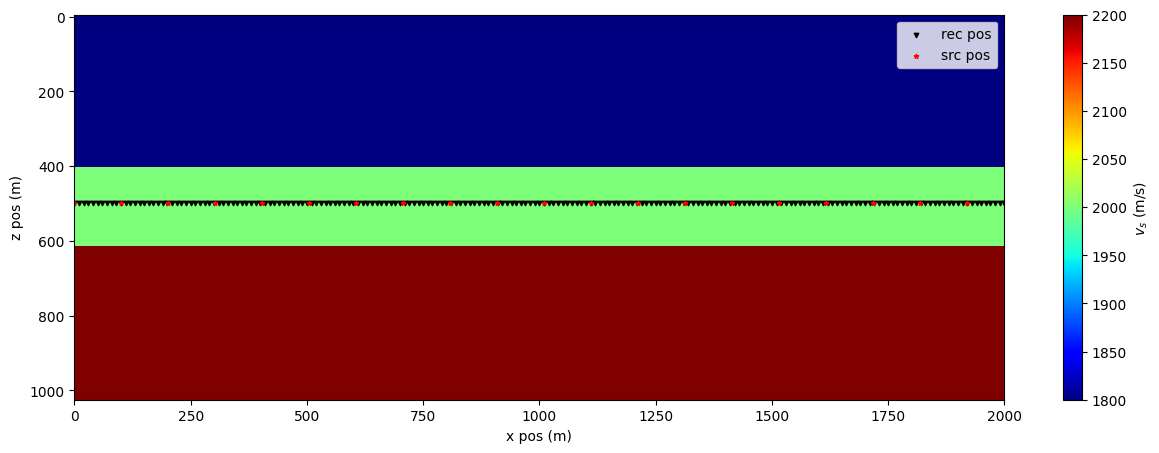

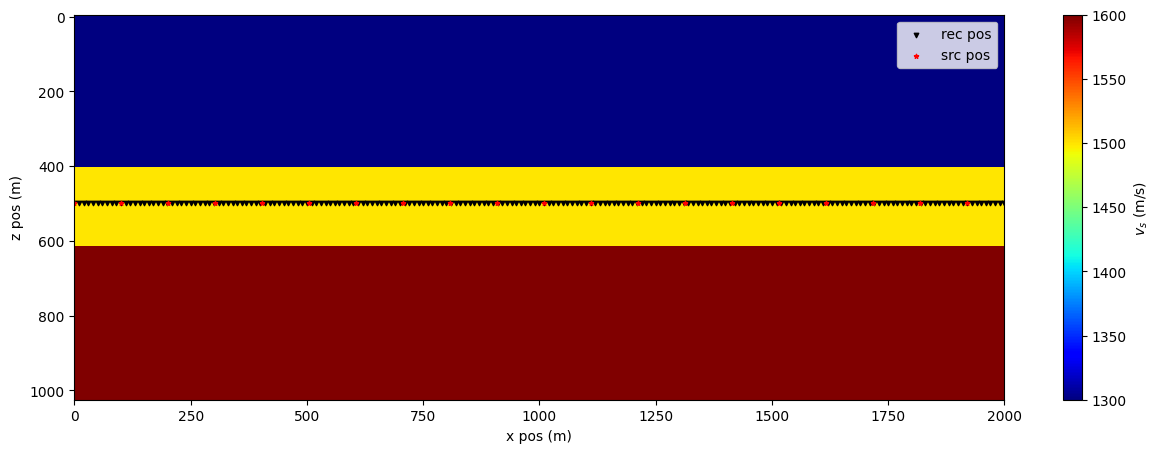

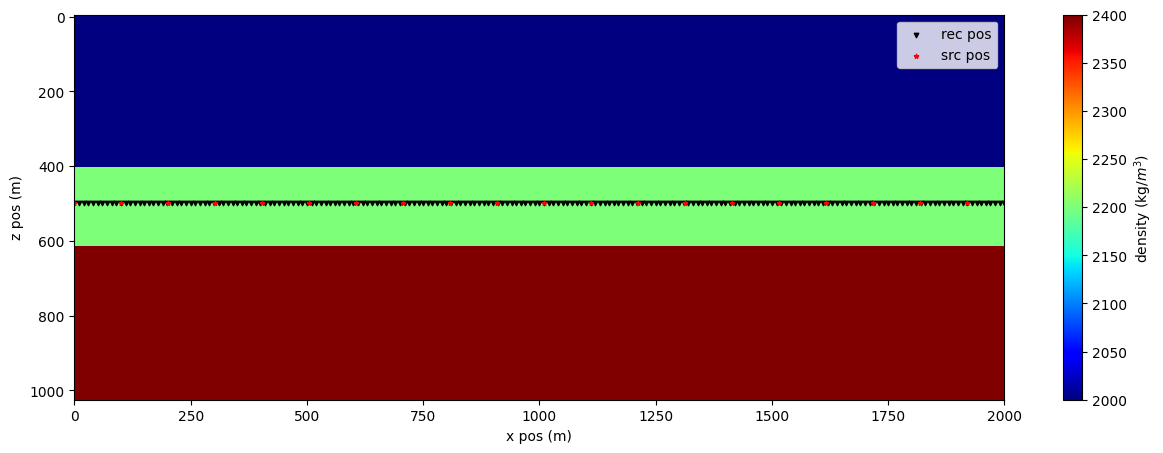

In [4]:
labels = ['$v_s$ (m/s)','$v_s$ (m/s)','density (kg/$m^3$)']
for model, label in zip(ela_model, labels):
    plotting.plot_model(model,
                        sampling=(d_x,d_z),
                        cbar=True,
                        src_locations=srcs,
                        rec_locations=recs,
                        vlims=[model.min(),
                               model.max()],
                        cbar_label=label)

## Make elastic wavelet with only vertical forcing term $f_z$

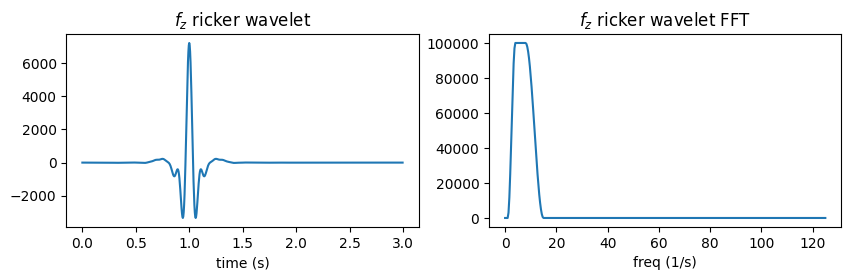

In [5]:
# make an explosive Ricker wavelet. f_x = f_z = s_xz = 0.0 | s_xx, s_xx != 0.0
n_t = 750
d_t = 0.004
delay = 1.0
ricker = Elastic2D.ElasticIsotropicTrapezoid2D(n_t, d_t, 1.0, 4.0, 8.0, 15.0, delay=delay).arr

# set everything but f_z to zero
scale=1e5 
ricker[1] = scale * ricker[2]
ricker[0] = 0.0
ricker[2:] = 0.0

# plot jsut
plotting.plot_wavelet(ricker[1],d_t,title='$f_z$ ricker wavelet')

## make 2d elastic wave equation solver

In [6]:
# make 2d acoustic wave equation solver
elastic_2d = elastic_isotropic.ElasticIsotropic2D(
  model=ela_model,
  model_sampling=(d_x,d_z),
  model_padding=(100, 100),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3],
  recording_components=['vx'])

## Make observed data

CPU times: user 26.9 s, sys: 2.17 s, total: 29.1 s
Wall time: 2.81 s


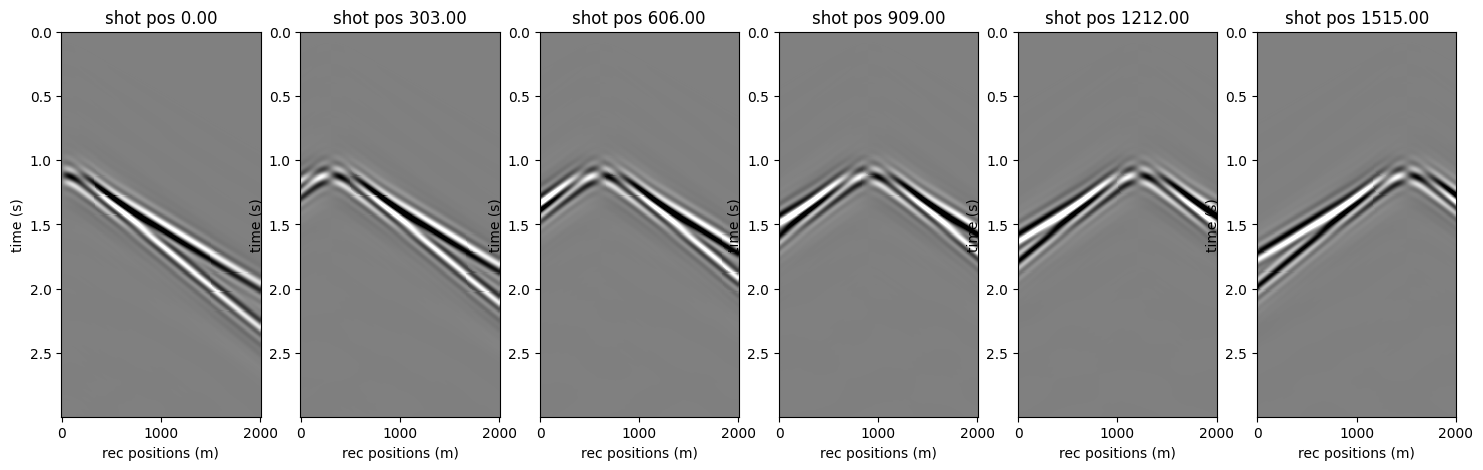

In [7]:
%%time
data_obs = elastic_2d.forward(ela_model)
# data_obs = np.squeeze(data_obs)

plotting.plot_data(np.squeeze(data_obs),
          d_t,
          src_locations=x_src,
          rec_locations=x_rec)

## Make starting model

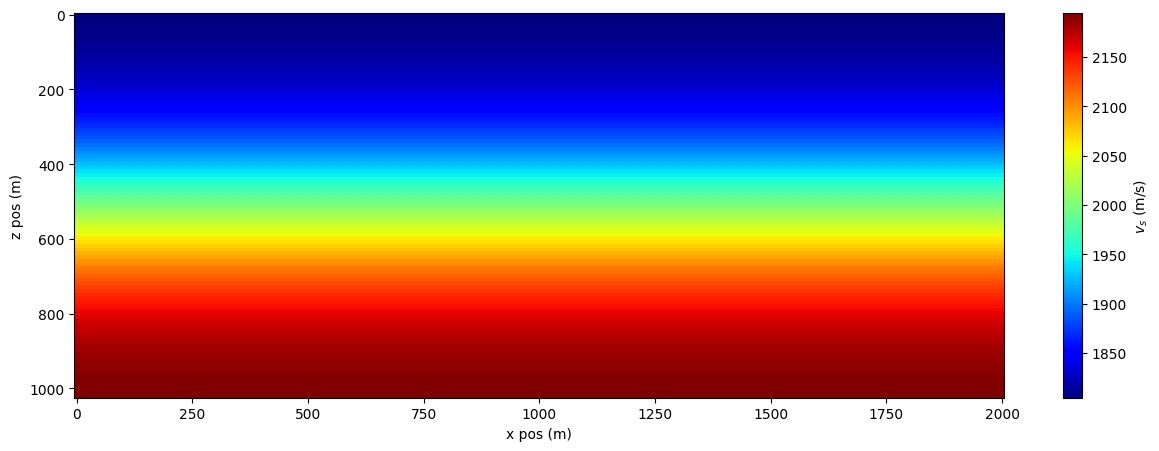

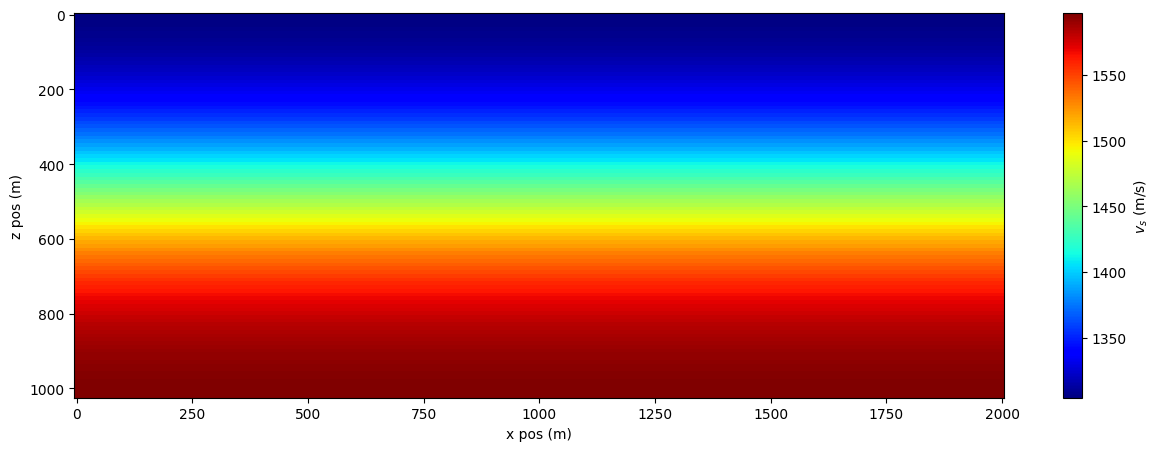

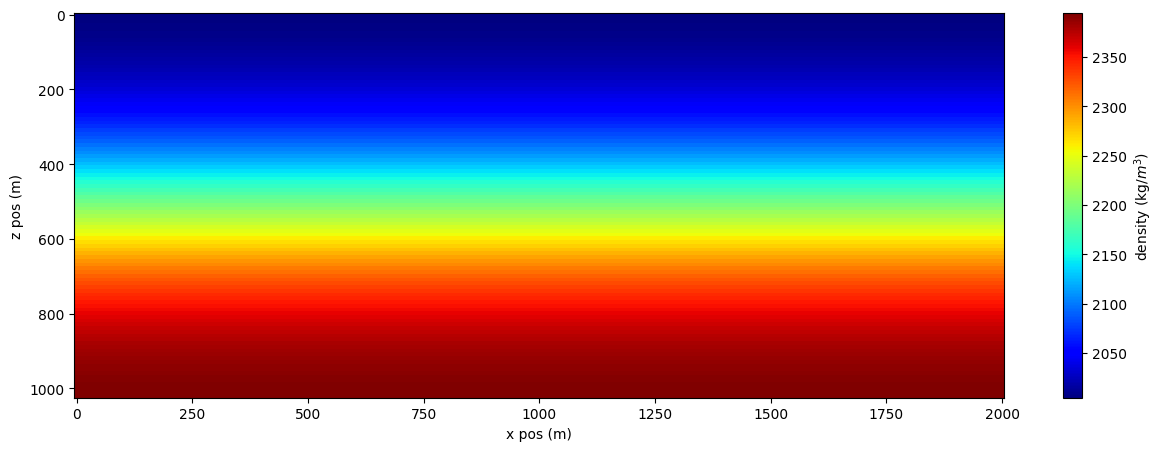

In [8]:
starting_model = ndimage.gaussian_filter(ela_model, (0, 20, 20), mode='nearest')

for model, label in zip(starting_model, labels):
    plotting.plot_model(model,
                        sampling=(d_x,d_z),
                        cbar=True,
                        vlims=[model.min(),
                               model.max()],
                        cbar_label=label)

## Create elastic fwi solver

In [9]:
fwi_prob = inversion.Fwi(elastic_2d,
                         data_obs,
                         starting_model,
                         num_iter=20,
                         iterations_per_save=5)

In [10]:
%%time

history = fwi_prob.run()

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2023-01-25T22-53-01.202371/
##########################################################################################

iter = 00, obj = 2.58561e-09, resnorm = 7.19e-05, gradnorm = 1.37e-12, feval = 1, geval = 1
iter = 01, obj = 1.18311e-09, resnorm = 4.86e-05, gradnorm = 9.98e-13, feval = 4, geval = 2
iter = 02, obj = 6.89258e-10, resnorm = 3.71e-05, gradnorm = 5.63e-13, feval = 7, geval = 3
iter = 03, obj = 5.05212e-10, resnorm = 3.18e-05, gradnorm = 4.81e-13, feval = 10, geval = 4
iter = 04, obj = 3.58148e-10, resnorm = 2.68e-05, gradnorm = 3.38e-13, feval = 13, geval = 5
iter = 05, obj = 2.93200e-10, resnorm = 2.42e-05, gradnorm = 3.22e-13, feval = 16, geval = 6
iter = 06, obj = 2.27014e-10, resnorm = 2.13e-05, gradnorm = 2.38e-13, feval = 19, geval = 7
iter = 07, obj = 1.80600e-10, resnorm = 1.90e-05, gradnorm = 

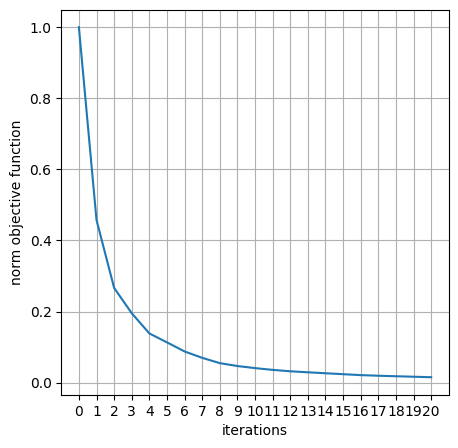

In [11]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

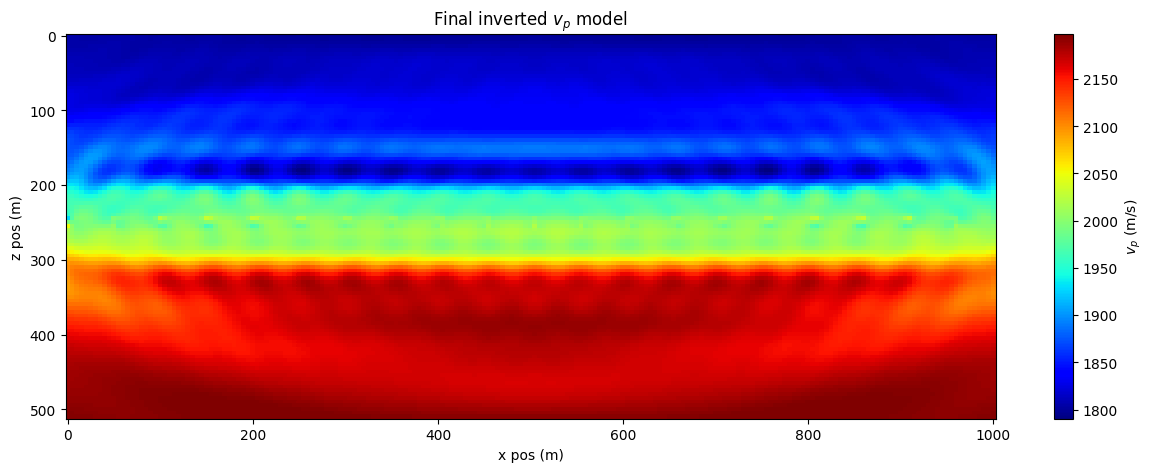

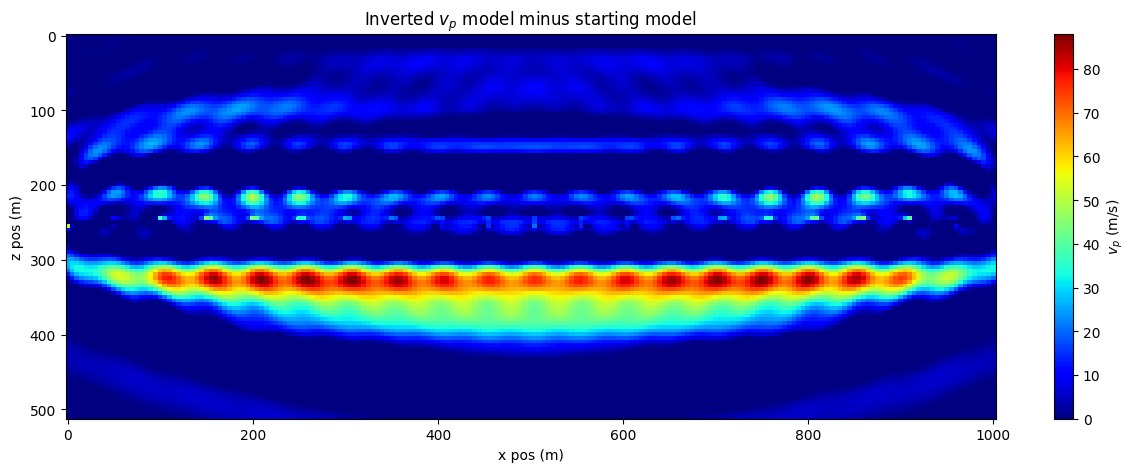

In [12]:
plotting.plot_model(history['inv_mod'][0],
           title='Final inverted $v_p$ model', 
           vlims=[history['inv_mod'][0].min(),
           history['inv_mod'][0].max()],
           cbar=True)

plotting.plot_model(history['inv_mod'][0]-starting_model[0],
           title='Inverted $v_p$ model minus starting model', 
           cbar=True,
          pclip=100)